<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/Chapter_4_Dynamic_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
#@title Dependencies
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (6, 6)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

## Chapter 4. Dynamic Programming



### 4.1 Policy Evaluation

---

Let's reproduce Figure 4.1 from the book (page 77). We want to implement policy iteration and show that the policy converges to the optimal policy -- satisfying the Bellman optimality equations -- within a finite number of steps. ($v_{k} \to v_\pi$ as $k \to \infty$).

We follow the in-place iterative policy evaluation algorithm on page 75.


In [22]:
def is_terminal(state: np.array) -> bool:
    '''
    Assume that upper left and bottom right are terminal states. 
    
    Args:
        state: the (x, y) coordinates of the grid world.
    Return:
        Whether the state is a terminal state (True) or not (False).
    '''
    x, y = state
    if (x == 0 and y == 0) or (x == N_ROWS-1 and y == N_COLS-1): 
        return True
    else:
        return False

In [23]:
def step(state: np.array, action: int) -> Tuple[np.array, int]:
    '''
    Take a step in the small grid world.

    Args:
        state: the (x, y) coordinates; current position of the agent.
        action: the selected action.
    Returns:
        next_state: the position of the agent after taking the action in the state.
        reward: the reward signal optained.
    '''
    # Check if the agent is in a terminal state
    if is_terminal(state):
        return (
            state, 0
        )
    
    # Take action
    next_state = state + action

    # make sure we stay inside our grid world
    x, y = next_state
    if x < 0 or (x > N_ROWS-1) or y < 0 or (y > N_COLS-1):
        next_state = state     
    reward = -1

    #print(f'State: {state}')
    #print(f'Next state: {next_state}')

    return next_state, reward

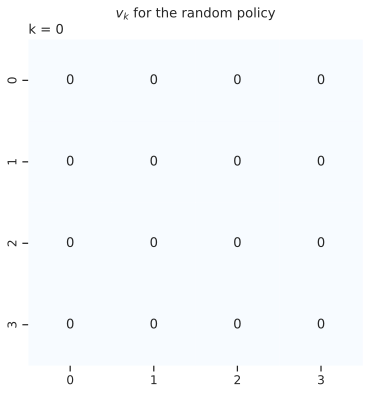

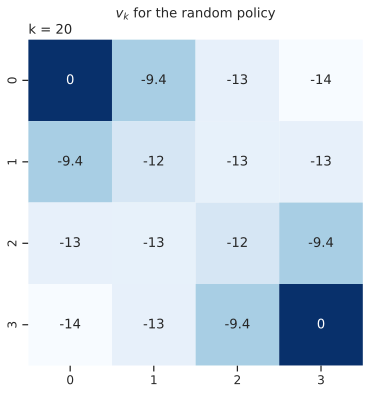

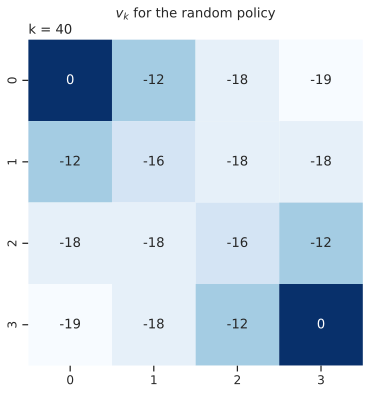

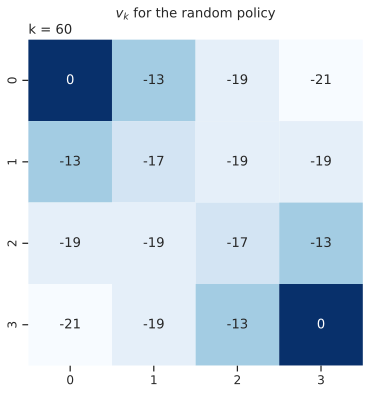

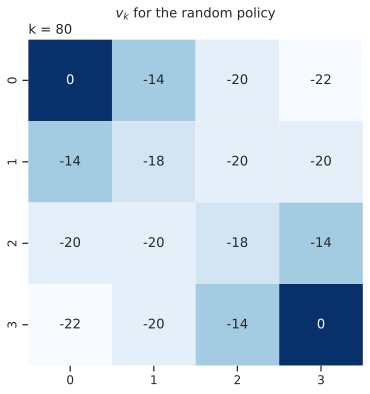

In [24]:
# Create a simple grid world
N_ROWS = 4
N_COLS = 4

# Left, right, up, down
ACTIONS = (
    np.array([0, -1]),
    np.array([0, 1]),
    np.array([1, 0]),
    np.array([-1, 0]),
)

# Use a random policy; all actions are equally likely
PI_RAND = 1 / len(ACTIONS)

# Parameters
TERMINATE = False
THETA = 1e-2
iters = 0
GAMMA = 1

# Create grid to track the value of each state
new_state_values = np.zeros((N_ROWS, N_COLS))

while not TERMINATE:
    
    # Current is new and previous is old
    state_values = new_state_values.copy()
    old_state_values = state_values.copy()

    # Loop for each state s 
    for row_i in range(N_ROWS):
        for col_i in range(N_COLS):
            state_value = 0 
            for action in ACTIONS:
                state = np.array([row_i, col_i])

                next_state, reward = step(state, action)

                # Add reward to state value
                state_value += PI_RAND * (reward + GAMMA * state_values[next_state[0], next_state[1]])

            # Update state value after we've gone through each action
            new_state_values[row_i, col_i] = state_value

    # Show approximation of the state-value function
    if iters % 20 == 0:
        sns.heatmap(state_values, annot=True, cbar=False, cmap='Blues')
        plt.title(f'k = {iters}', loc='left')
        plt.title(r'$v_k$ for the random policy', y=1.05)
        plt.show();
        print('')

    iters += 1

    # Check termination condition 
    DELTA = abs(old_state_values - new_state_values).max()
    if DELTA < THETA:
        TERMINATE = True

### 4.3 Policy Iteration

---

We implement **Exercise 4.7** and write a program for policy iteration to solve Jack's car rental problem exactly as shown in Figure 4.2 (See the policy iteration algorithm on page 80).

$$
$$

**Intuition:** start with a guess policy --> evaluate --> improve it --> evaluate again --> improve it --> and so on!

### 4.3.1 Setup and Initialization

In [60]:
def step(state: np.array, action: int) -> Tuple[np.array, int]:
    '''
    Interact with the environment.

    Args:
        state: [ number of cars in loc A, number of cars in loc B]
        action: a number indicating how many cars to move.
    Return:
        next_state: [ number of cars in loc A, number of cars in loc B]
        reward: how many cars could be rented out at each location.
    '''

    # Sample the number of cars requested at each location
    num_cars_req_loc_a = np.random.poisson(LAMBDA_REQ_LOC_A, size=1)
    num_cars_req_loc_b = np.random.poisson(LAMBDA_REQ_LOC_B, size=1)

    # Sample the number of cars returned at each location
    num_cars_ret_loc_a = np.random.poisson(LAMBDA_RETURN_LOC_A, size=1)
    num_cars_ret_loc_b = np.random.poisson(LAMBDA_RETURN_LOC_B, size=1)

    # Update state with moved cars
    if action < 0:
        state[0] += abs(action)
        state[1] -= abs(action)
    else:
        state[0] -= abs(action)
        state[1] += abs(action)

    # Update state with requested and returned cars
    state[0] += (num_cars_ret_loc_a - num_cars_req_loc_a)
    state[1] += (num_cars_ret_loc_b - num_cars_req_loc_b)
 
    # Assume that there can be no more than 20 cars at each location
    for i in range(2):
        if state[i] > MAX_CARS:
            state[i] = 20
    
    reward = state.sum() * CAR_REWARD

    return state, reward

In [87]:
'''
Parameters
'''

SEED = 42
np.random.seed(SEED)

# Pay for renting out a car 
CAR_REWARD = 10

# Cars can be moved from one loc to the other
CAR_MOVE_COST = 2

# Assume that the number of cars requested and returned at each location are Poisson random variables
LAMBDA_REQ_LOC_A = 3
LAMBDA_RETURN_LOC_A = 3
LAMBDA_REQ_LOC_B = 4
LAMBDA_RETURN_LOC_B = 2

# Assume that there can be no more than 20 cars per location
MAX_CARS = 20

# The maximum cars that can be moved overnight
MAX_MOVING_CARS = 5

# Discount rate
GAMMA = 0.9

# The action indicates how many cars to move from point A to B or B to A
# Positive: move cars from A --> B | Negative: move cars from B --> A
ACTIONS = np.arange(-MAX_MOVING_CARS, MAX_MOVING_CARS + 1)

# Generate all possible states
posib_state_pairs = list(itertools.permutations(np.arange(MAX_CARS), 2))


In [88]:
len(posib_state_pairs)

posib_state_pairs[-1]

(19, 18)

### 4.3.2 Policy Evaluation

In [101]:
# Initialization
NUM_CARS = 20
new_car_state_values = np.zeros((NUM_CARS+1, NUM_CARS+1))

# Parameters
TERMINATE = False
THETA = 1e-2
MAX_ITERS = 50
iters = 0

# Start with a random policy
PHI_RAND = 1 / len(ACTIONS)

while not TERMINATE:
    
    # Current is new and previous is old
    car_state_values = new_car_state_values.copy()
    car_old_state_values = car_state_values.copy()

    # Loop for each state s 
    for state in posib_state_pairs:
        state_value = 0 
        for action in ACTIONS:
            # Get reward and next state
            next_state, reward = step(np.array(state), action)

            # Add reward to state value
            state_value += PI_RAND * (reward + GAMMA * car_state_values[next_state[0], next_state[1]])

        # Update state value after we've gone through each action
        new_car_state_values[state[0], state[1]] = state_value

    iters += 1

    # Check termination condition 
    DELTA = abs(car_old_state_values - new_car_state_values).max()
    if DELTA < THETA or iters == MAX_ITERS:
        TERMINATE = True

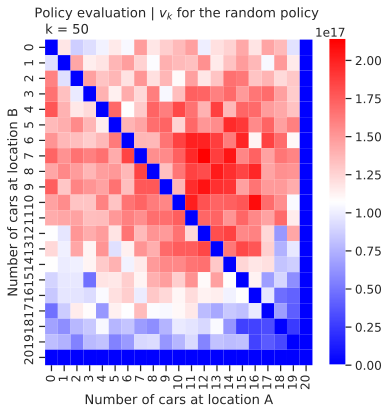

In [108]:
sns.heatmap(car_state_values, cbar=True, cmap='bwr')
plt.title(f'k = {iters}', loc='left')
plt.title(r'Policy evaluation | $v_k$ for the random policy ', y=1.05)
plt.xlabel('Number of cars at location A')
plt.ylabel('Number of cars at location B');